In [1]:
import matplotlib.pyplot as plt
import numpy as np
import sympy as sy
from sympy import Derivative, Symbol
from scipy.special import sph_harm 
from scipy import integrate
from scipy.integrate import dblquad
from scipy.integrate import quad

In [2]:
N_t = 50
N_p = 100
theta = np.linspace(1e-4, np.pi, N_t) #make the starting point very small
phi = np.linspace(0, 2*np.pi, N_p) 
t, p = np.meshgrid(theta, phi)
lMax = 20 #lMax is N
omega = 3.6 #omega is te angular rotation
nu = 1.5  #\nu is kinematic viscosity
T = 4 #total time
r = 1
#let r=1

U_tp = -2*np.cos(t)*np.cos(p)*np.sin(p)/r #this is obtained by analytical calculation
V_tp = -np.sin(t)**2*np.sin(p)**2/r

Input Streamfunction:

$$
\psi (\theta, \phi)=\cos(\theta) \sin^2(\phi)
$$

Analytical expression for U and V:

$$
U(\theta, \phi)=-\frac{1}{r} \frac{\partial \psi}{\partial \phi} = -\frac{2\cos\theta\cos\phi\sin\phi}{r}
$$

$$
V(\theta, \phi)=\frac{\sin \theta}{r}\frac{\partial \psi}{\partial \theta} = \frac{-\sin^2\theta\sin^2\phi}{r}
$$

In [3]:
#U_tp_n is the numerical expression of U_tp
psi_TP = np.cos(t)*np.sin(p)**2
U_tp_n = -(1/r)*np.gradient(psi_TP, phi, axis=0)
V_tp_n = (np.sin(t)/r)*np.gradient(psi_TP, theta, axis=1)
print ("max difference between numerical and analytical calculated U\n",np.amax(np.abs(U_tp_n-U_tp)))
print ("max difference between numerical and analytical calculated V\n",np.amax(np.abs(V_tp_n-V_tp)))

max difference between numerical and analytical calculated U
 0.06338134965088181
max difference between numerical and analytical calculated V
 0.0006840457214857265


The equation used for projection of the spherical harmonics: 
$$
\begin{equation}
    \psi_{nm}=\int ^{2\pi}_0 \int^\pi_0 \psi(\theta, \phi)(Y^m_n(\theta,\phi))^\ast \sin \theta d\theta d\phi
\end{equation}
$$

In [4]:
def projection(f_tp, theta, phi, lMax): # Projection onto sph_harm: takes f(theta,phi) as input and returns f_{nm}
    t, p = np.meshgrid (theta, phi)
    f_nm = np.zeros((lMax, lMax), dtype=complex)
    for m in range (lMax): 
        for n in range (m, lMax):
            Y_nm = sph_harm (m, n, p.reshape(-1), t.reshape(-1))
            Y_ast = np.conj(Y_nm.reshape(N_p, N_t))
            f_nm[n,m] = integrate.simpson(integrate.simpson(f_tp*Y_ast*np.sin(t), theta), phi)
    return f_nm

The equation used for reconstruction:
$$
\begin{equation}
    \psi (\theta, \phi) = \sum ^{N}_{\lvert m \rvert = 0} \sum ^{N}_{n=\lvert m \rvert} \psi_{nm} Y^m_n(\theta, \phi)
\end{equation}
$$

In [5]:
def reconstruction(f_nm, theta, phi, lMax):  #Reconstruction from sph_harm, takes f_{nm} and returns f(theta,phi)
    f_TP = np.zeros((N_p, N_t))
    #double sum
    for m in range(lMax):
        for n in range(m, lMax):
            Y_nm = sph_harm (m, n, p.reshape(-1), t.reshape(-1)).reshape(N_p, N_t)
            if m==0:
                f_TP += np.real(f_nm[n,m]*Y_nm) # A+=B is equivalent to A=A+B
            else:
                f_TP += 2.*np.real(f_nm[n,m]*Y_nm) #the negative value need to also be accounted for
    return f_TP

In [6]:
u_nm = projection(U_tp, theta, phi, lMax) #project U_tp to u_nm
v_nm = projection(V_tp, theta, phi, lMax) 

In [7]:
U_TP = reconstruction(u_nm, theta, phi, lMax) #reconstructed U(theta, phi) using u_nm
V_TP = reconstruction(v_nm, theta, phi, lMax) 

In [8]:
print ("max difference between original and reconstructed U\n",np.amax(np.abs(U_TP-U_tp)))
print ("max difference between original and reconstructed V\n",np.amax(np.abs(V_TP-V_tp)))

max difference between original and reconstructed U
 0.9998741276738751
max difference between original and reconstructed V
 0.00020217160933337956


Analytical expression of different quantities:
$$
\begin{equation}
    \zeta_{nm}=-in(n+1)m^{-1}u_{nm}
\end{equation}


\begin{equation}
    U'(\theta, \phi)=V\zeta+2\Omega V \cos\theta
\end{equation}


\begin{equation}
    V'(\theta, \phi)=-U\zeta-2\Omega U \sin \theta
\end{equation}


\begin{equation}
    \nabla^2P=-\frac{\partial U'}{\partial \cos\theta}+\frac{1}{\sin^2\theta}\frac{\partial V'}{\partial \phi} = \frac{\partial U'}{\sin\theta\partial \theta}+\frac{1}{\sin^2\theta}\frac{\partial V'}{\partial \phi}
\end{equation}


\begin{equation}
    p_{nm}=\frac{-1}{n(n+1)}(\nabla^2P)_{nm}
\end{equation}
$$

In [9]:
zeta_nm = np.zeros((lMax, lMax), dtype=complex)
for m in range (1, lMax):
    for n in range (m, lMax):
        zeta_nm[n,m] = -1j*(n*(n+1)/m)*u_nm[n,m]

zeta_tp = reconstruction(zeta_nm, theta, phi, lMax)
U1_tp = V_TP*zeta_tp+2*omega*np.cos(t)*V_TP #U'(theta, phi)
V1_tp = -1*U_TP*zeta_tp-2*omega*np.cos(t)*U_TP #V'(theta, phi)
u1_nm = projection(U1_tp, theta, phi, lMax) #u'_nm
v1_nm = projection(V1_tp, theta, phi, lMax) #v'_nm

divP = -1*np.gradient(U1_tp, np.cos(theta), axis=1)+(1/(np.sin(theta)**2))*np.gradient(V1_tp, phi, axis=0) #\nabla^1 P
    
divP_nm = projection(divP, theta, phi, lMax) #\nabla^2 P_nm
p_nm = np.zeros((lMax, lMax), dtype=complex)
for m in range (1, lMax):
    for n in range (m, lMax):
        p_nm[n,m] = (-1/(n*(n+1)))*divP_nm[n,m]

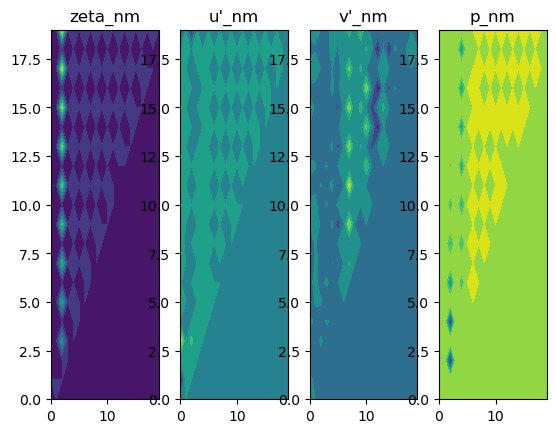

In [10]:
fig,ax = plt.subplots(1,4);
ax[0].contourf(np.real(zeta_nm))
ax[0].set_title('zeta_nm')
ax[1].contourf(np.real(u1_nm))
ax[1].set_title("u'_nm")
ax[2].contourf(np.real(v1_nm))
ax[2].set_title("v'_nm")
ax[3].contourf(np.real(p_nm))
ax[3].set_title('p_nm')
fig.show()

For the above arbitrary stream function $$ \psi (\theta, \phi)=\cos\theta\sin^2\phi $$ 

The analytical expression of the harmonics quantities is calculated as:

$$
\zeta = \frac{-2\cos\theta\sin^2\phi}{r^2} + \frac{2\cos\theta}{r\sin^2\theta}(\cos^2\phi-\sin^2\phi)
$$

$$
U' = A_1\cos\theta\sin^2\theta - A_2 \cos\theta
$$
with
$$
A_1 = \frac{2\sin^4\phi}{r^3}-\frac{2\Omega\sin^2\phi}{r}\\
A_2 = \frac{2\sin^2\phi}{r^2}(\cos^2\phi-\sin^2\phi)
$$

$$
V' = B\cos^3\phi\sin\phi+C\cos\phi\sin\phi+D\cos\phi\sin^3\phi
$$
with

$$
B = \frac{4}{r^2\tan^2\theta}\\
C = \frac{4\Omega\cos\theta\sin\theta}{r}\\
D = \frac{-4\cos^2\theta}{r^2}(\frac{1}{r}+\frac{1}{\sin^2\theta})
$$

$$
\nabla^2P = 2A_1\cos^2\theta-A_1\sin^2\theta+A_2 + \frac{1}{\sin^2\theta}(B\cos^4\phi+C\cos^2\phi-C\sin^2\phi-D\sin^4\phi+3\cos^2\phi\sin^2\phi(D-B))
$$

$$
\quad
\textbf{Entre analytical expression for result comparison}
$$

max difference between numerical and analytical zeta_nm
 65404076499.546875
max difference between numerical and analytical zeta
 1.3335468940567855e+32


/opt/conda/lib/python3.10/site-packages/matplotlib/cbook/__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


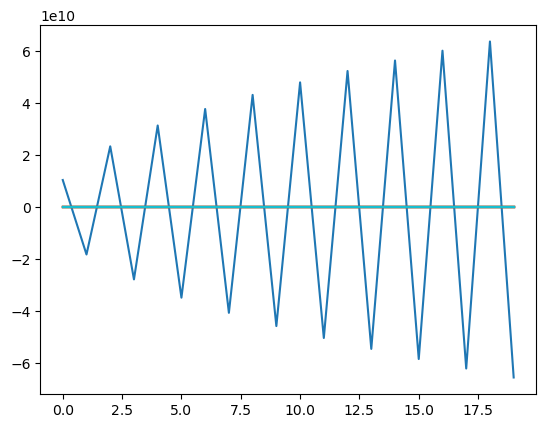

In [11]:
#analytical zeta(theta, phi)

zetaA_tp = (-2*np.cos(t)*np.sin(p)**2/(r**2))+(2*np.cos(t)*(np.cos(p)**2-np.sin(p)**2))/(r*np.sin(t)**2)

zetaA_nm = projection(zetaA_tp, theta, phi, lMax)
print ("max difference between numerical and analytical zeta_nm\n",np.amax(np.abs(zetaA_nm-zeta_nm)))
print ("max difference between numerical and analytical zeta\n",np.amax(np.abs(zetaA_tp-zeta_tp)))
plt.plot(zetaA_nm-zeta_nm)

max difference between numerical and analytical U1_tp
 3.8132621072520334
max difference between numerical and analytical u1_nm
 1.6223614611686854


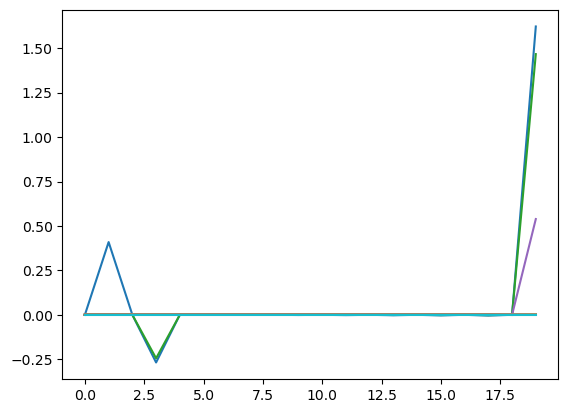

In [15]:
#analytical U'(theta, phi)

A_1 = (2*np.sin(p)**4/(r**3))-(2*omega*np.sin(p)**2/r)
A_2 = 2*np.sin(p)**2*(np.cos(p)**2-np.sin(p)**2)/(r**2)
U1A_tp = A_1*np.cos(t)*np.sin(t)**2-A_2*np.cos(t)

u1A_nm = projection(U1A_tp, theta, phi, lMax)
print ("max difference between numerical and analytical U1_tp\n",np.amax(np.abs(U1A_tp-U1_tp)))
print ("max difference between numerical and analytical u1_nm\n",np.amax(np.abs(u1A_nm-u1_nm)))
plt.plot(u1A_nm-u1_nm)

max difference between numerical and analytical V1_tp
 6.666895187036168e+31
max difference between numerical and analytical v1_nm
 4.596533521205472


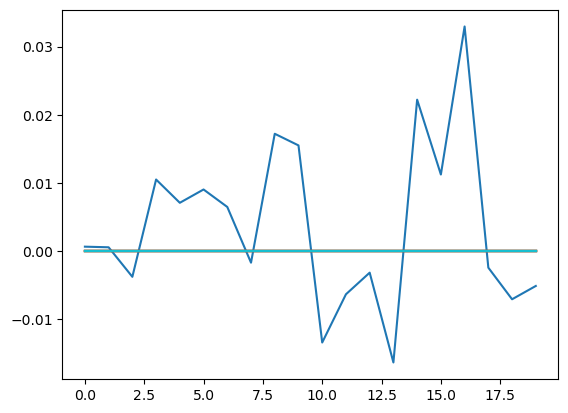

In [17]:
#analytical V'(theta, phi)

B=4/(r**2*np.tan(t)**2)
C=4*omega*np.cos(t)*np.sin(t)/r
D=-4*np.cos(t)**2*((1/r)+(1/(np.sin(t)**2)))/(r**2)
V1A_tp = B*np.cos(p)**3*np.sin(p)+C*np.cos(p)*np.sin(p)+D*np.cos(p)*np.sin(p)**3

v1A_nm = projection(V1A_tp, theta, phi, lMax)
print ("max difference between numerical and analytical V1_tp\n",np.amax(np.abs(V1A_tp-V1_tp)))
print ("max difference between numerical and analytical v1_nm\n",np.amax(np.abs(v1A_nm-v1_nm)))

plt.plot(v1A_nm-v1_nm)


max difference between numerical and analytical divP
 1.7783473186484996e+64
max difference between numerical and analytical divP_nm
 3.474742194524193e+43


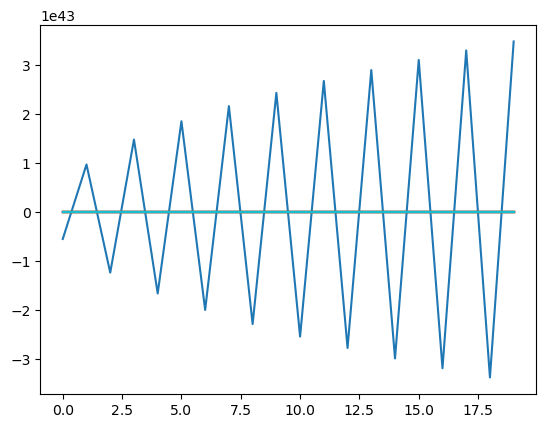

In [18]:
#analytical divP

divPA = 2*A_1*np.cos(t)**2-A_1*np.sin(t)**2+A_2+np.sin(t)**(-2)*(B*np.cos(p)**4+C*np.cos(p)**2-C*np.sin(p)**2-D*np.sin(p)**4+3*np.cos(p)**2*np.sin(p)**2*(D-B))

divPA_nm = projection(divPA, theta, phi, lMax)

print ("max difference between numerical and analytical divP\n",np.amax(np.abs(divPA-divP)))
print ("max difference between numerical and analytical divP_nm\n",np.amax(np.abs(divPA_nm-divP_nm)))

plt.plot(divPA_nm-divP_nm)
